In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from pymongo import MongoClient
import time
import datetime
import os
from pyculiarity import detect_ts
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from dendrogram_class import Dendrogram, make_dendrogram
import pickle
import itertools
from collections import defaultdict, Counter
import scipy.stats as scs
from scipy import signal
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
with open('data/csgo_features.pkl', 'rb') as f:
    df = pickle.load(f)

In [13]:
df.head()

,index,app,date,item_name,median_sell_price,quantity,release_date,parenthetical,gun_bool,StatTrak,souvenir,gun_type,skin,quality,keys,capsules,stickers,event_item,days_since_release
0,0,730,1.471583e+09,Glock-18 | Weasel (Battle-Scarred),6.193,135,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,0
1,1,730,1.471669e+09,Glock-18 | Weasel (Battle-Scarred),5.103,166,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,1
2,2,730,1.471756e+09,Glock-18 | Weasel (Battle-Scarred),4.721,142,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,2
3,3,730,1.471842e+09,Glock-18 | Weasel (Battle-Scarred),4.302,98,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,3
4,4,730,1.471928e+09,Glock-18 | Weasel (Battle-Scarred),3.898,125,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,4


In [14]:
df = df.drop(columns=['parenthetical', 'index'])

In [15]:
df.release_date.unique()

array(['18 August 2016', '17 February 2016', '27 April 2016', nan,
       '26 May 2015', '14 September 2017', '8 December 2015',
       '15 April 2015', '15 March 2017', '20 February 2014',
       '28 November 2016', '27 November 2013', '18 December 2013',
       '17 September 2015', '15 June 2016', '1 May 2014',
       '15 February 2018', '8 January 2015', '14 August 2013',
       '8 November 2013', '23 May 2017', '1 July 2014', '8 August 2014',
       '19 September 2013', '11 November 2014', '12 February 2014',
       '10 July 2014'], dtype=object)

In [18]:
df['num_sale_days'] = df.groupby('item_name')['days_since_release'].transform('max')
df['desc'] = df['item_name'] + ' ' + df['release_date']
# df_pivot = df_sub.reset_index().pivot('desc', 'num_sales_days', 'median_sell_price')

In [33]:
den = Dendrogram()
den.fit(df)

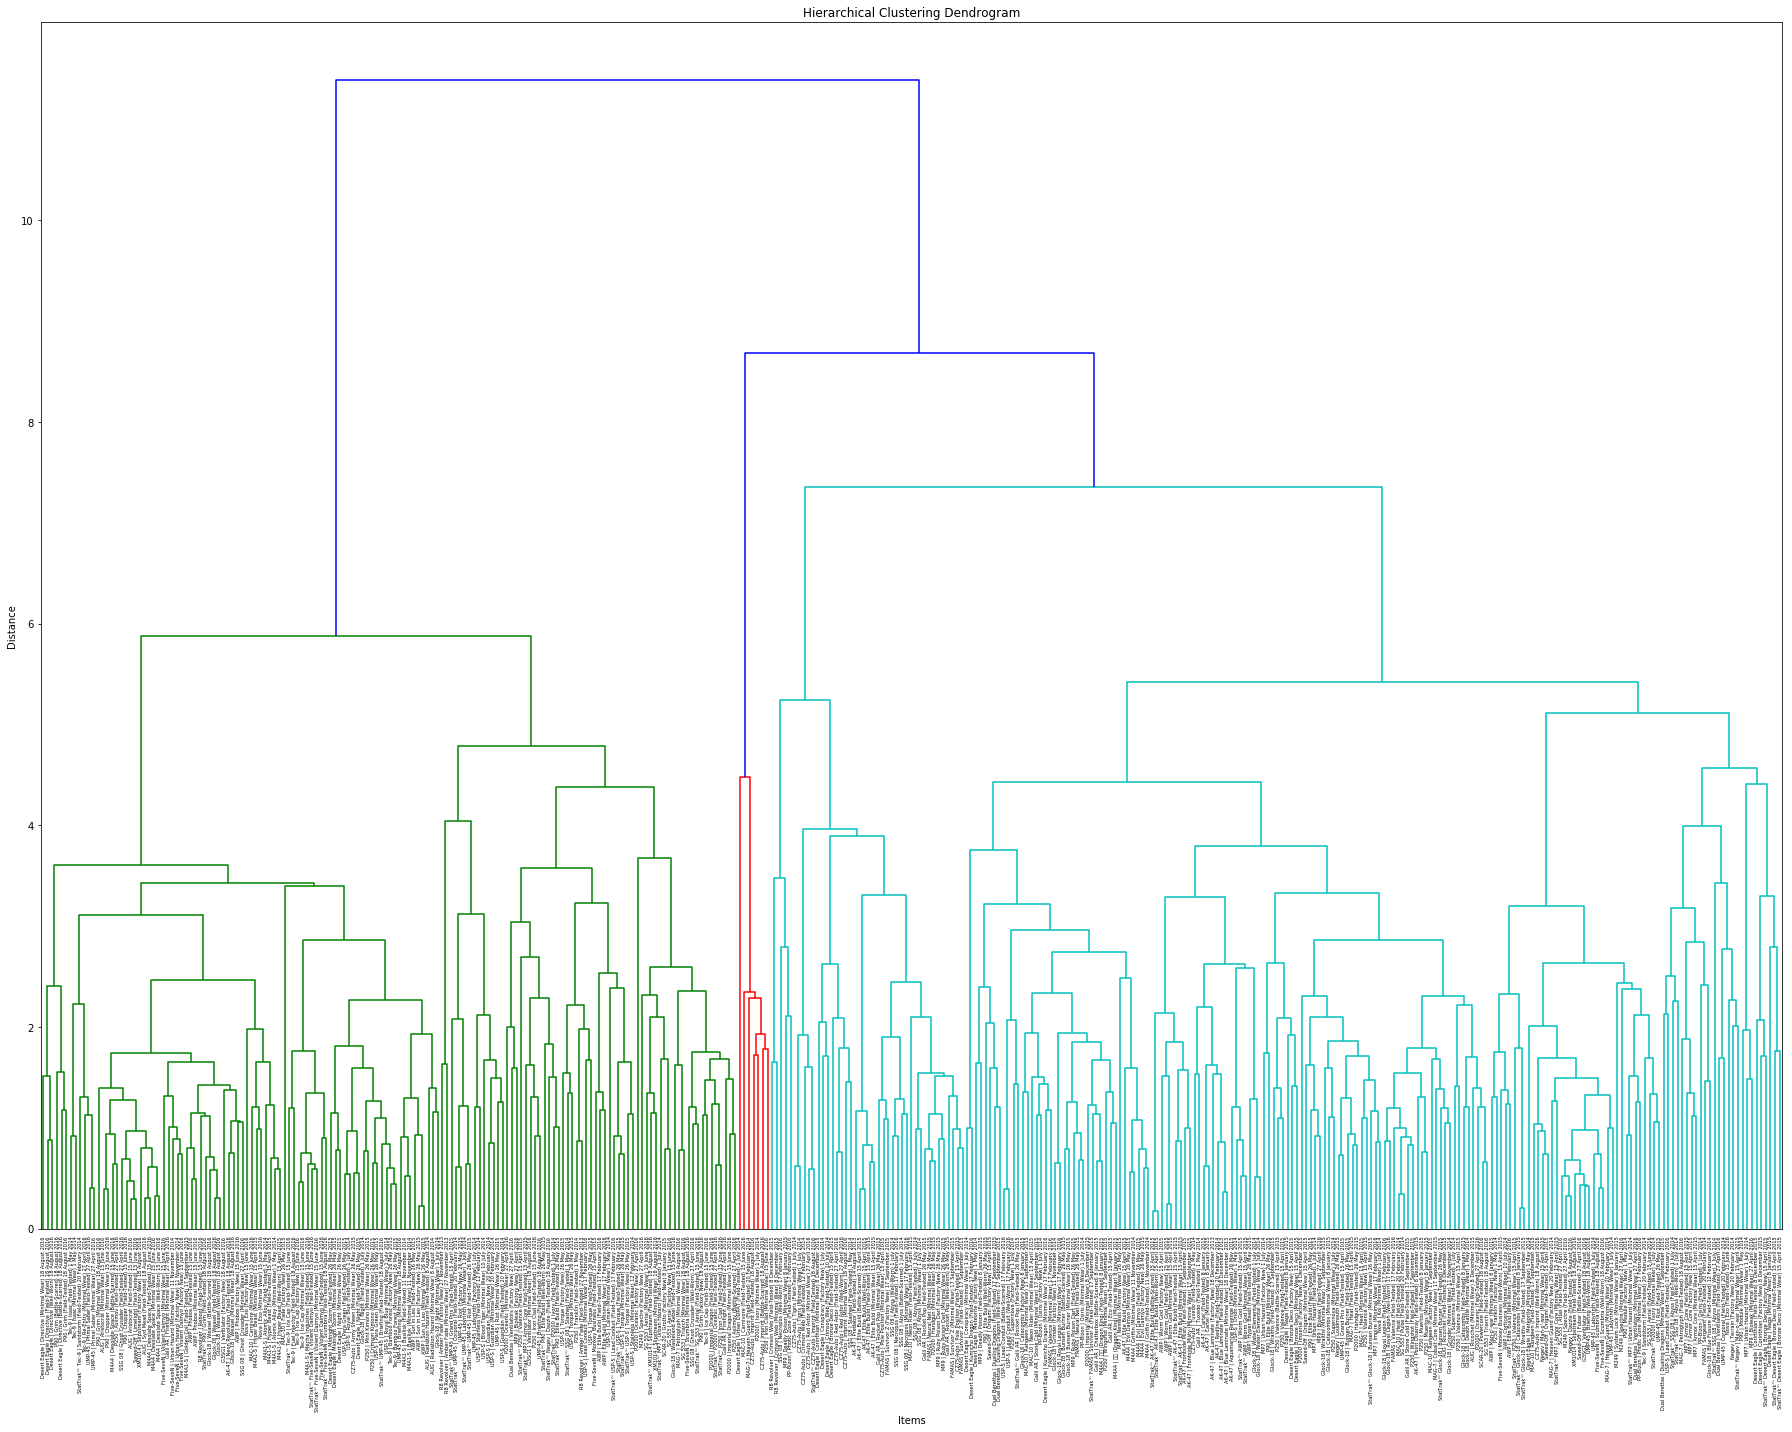

In [37]:
den.make_dendrogram(save=True)

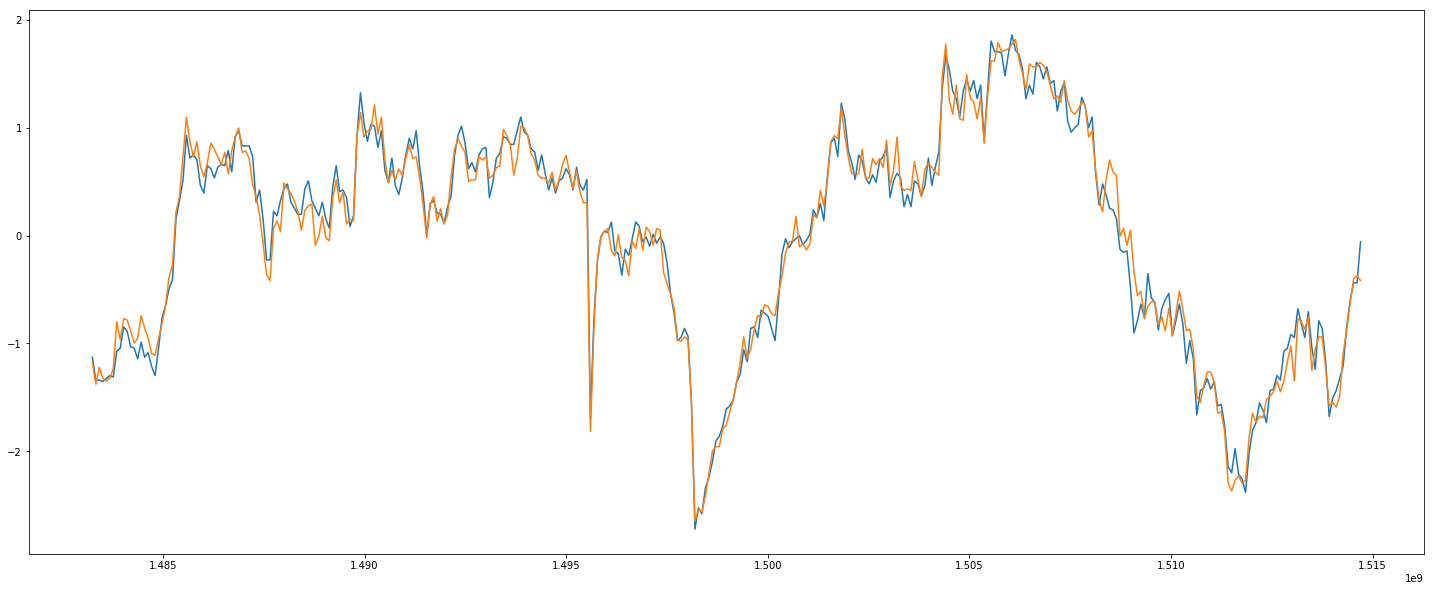

In [38]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(den.pivot.loc['StatTrak™ Glock-18 | Catacombs (Field-Tested) 8 January 2015'])
ax.plot(den.pivot.loc['StatTrak™ Glock-18 | Wraiths (Field-Tested) 17 September 2015'])

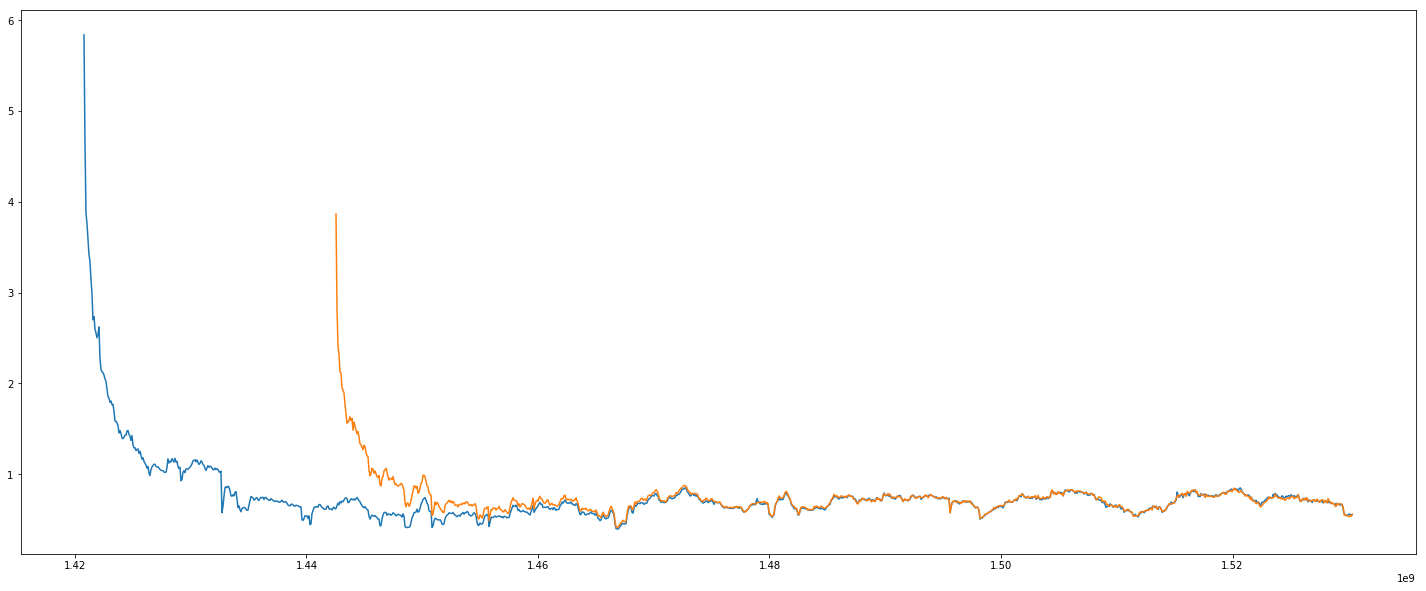

In [39]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(df[df.item_name=='StatTrak™ Glock-18 | Catacombs (Field-Tested)'].date, df[df.item_name=='StatTrak™ Glock-18 | Catacombs (Field-Tested)'].median_sell_price)
ax.plot(df[df.item_name=='StatTrak™ Glock-18 | Wraiths (Field-Tested)'].date, df[df.item_name=='StatTrak™ Glock-18 | Wraiths (Field-Tested)'].median_sell_price)

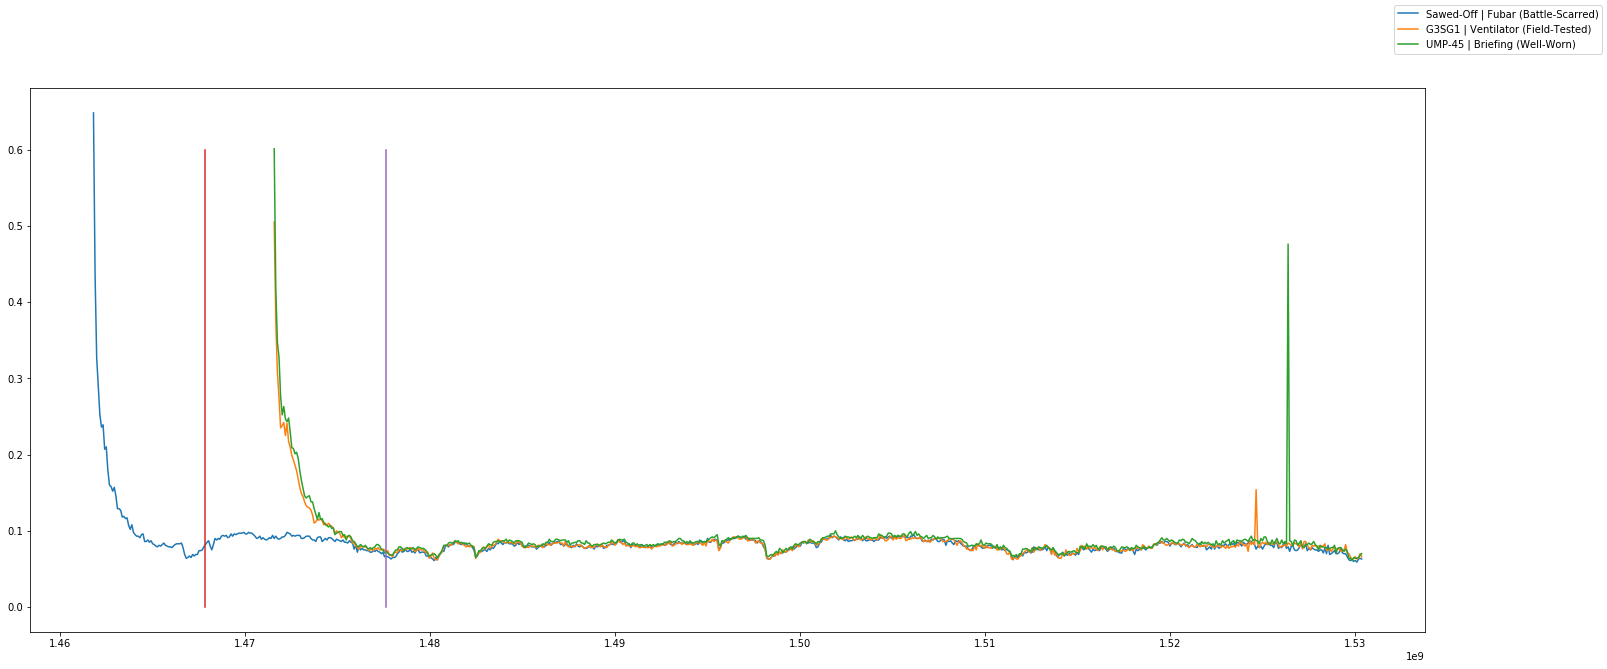

In [60]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].date, df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].median_sell_price, label='Sawed-Off | Fubar (Battle-Scarred)')
ax.plot(df[df.item_name=='G3SG1 | Ventilator (Field-Tested)'].date, df[df.item_name=='G3SG1 | Ventilator (Field-Tested)'].median_sell_price, label='G3SG1 | Ventilator (Field-Tested)')
ax.plot(df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].date, df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].median_sell_price, label='UMP-45 | Briefing (Well-Worn)')
ax.plot([df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].date.values[70]]*2, [0, 0.6])
ax.plot([df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].date.values[70]]*2, [0, 0.6])
fig.legend()

In [ ]:
ax.plot(df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].date, df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].median_sell_price, label='Sawed-Off | Fubar (Battle-Scarred)')
ax.plot(df[df.item_name=='G3SG1 | Ventilator (Field-Tested)'].date, df[df.item_name=='G3SG1 | Ventilator (Field-Tested)'].median_sell_price, label='G3SG1 | Ventilator (Field-Tested)')
ax.plot(df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].date, df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].median_sell_price, label='UMP-45 | Briefing (Well-Worn)')

In [56]:
shotty = df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)']
gsg = df[df.item_name=='G3SG1 | Ventilator (Field-Tested)']
ump = df[df.item_name=='UMP-45 | Briefing (Well-Worn)']

In [57]:
shotty = shotty[shotty.days_since_release > 70]
shotty = shotty[['date', 'median_sell_price']].reset_index(drop=True)
shotty.columns = ['timestamp', 'count']
shotty.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in shotty.timestamp]

gsg = gsg[gsg.days_since_release > 70]
gsg = gsg[['date', 'median_sell_price']].reset_index(drop=True)
gsg.columns = ['timestamp', 'count']
gsg.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in gsg.timestamp]

ump = ump[ump.days_since_release > 70]
ump = ump[['date', 'median_sell_price']].reset_index(drop=True)
ump.columns = ['timestamp', 'count']
ump.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in ump.timestamp]

In [58]:
results_shotty = detect_ts(shotty, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
results_gsg = detect_ts(gsg, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
results_ump = detect_ts(ump, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)

Text(0,0.5,'value')

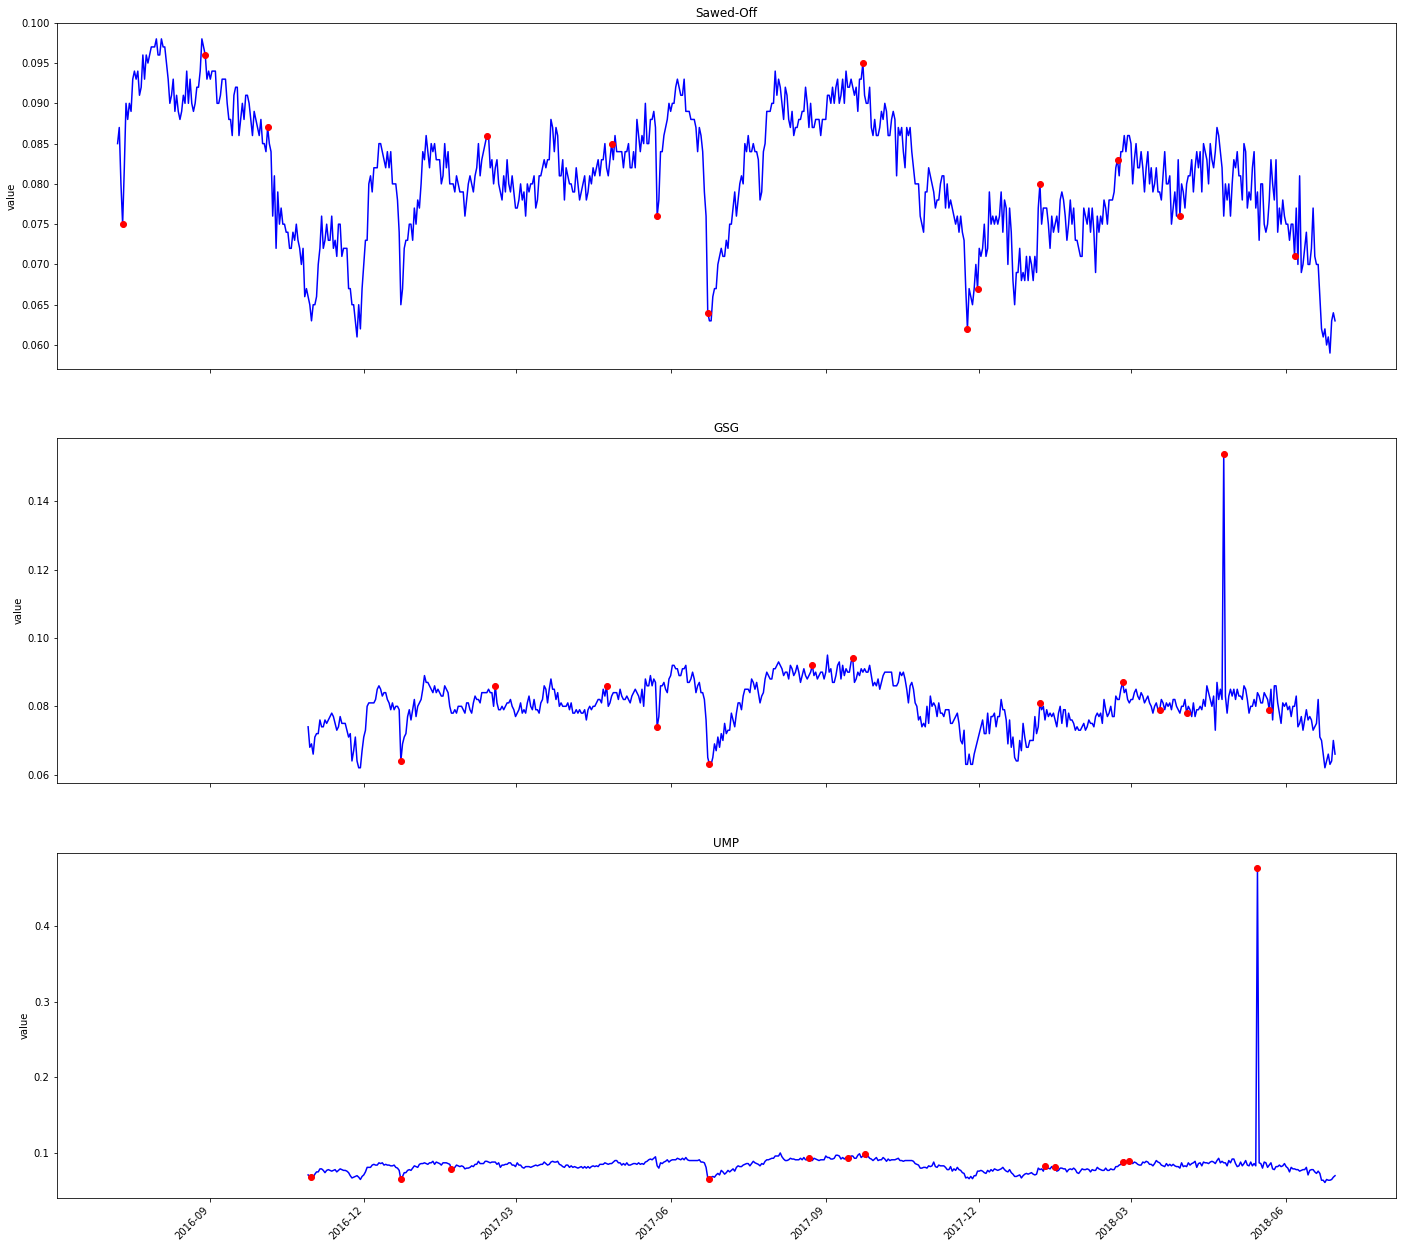

In [59]:
# make a nice plot
fig, ax = plt.subplots(3, 1, figsize=(24, 24), sharex=True)
fig.autofmt_xdate(rotation=45)

ax[0].plot(shotty['timestamp'], shotty['value'], 'b')
ax[0].plot(results_shotty['anoms'].index, results_shotty['anoms']['anoms'], 'ro')
ax[0].set_title('Sawed-Off')
ax[0].set_ylabel('value')

ax[1].plot(gsg['timestamp'], gsg['value'], 'b')
ax[1].plot(results_gsg['anoms'].index, results_gsg['anoms']['anoms'], 'ro')
ax[1].set_title('GSG')
ax[1].set_ylabel('value')

ax[2].plot(ump['timestamp'], ump['value'], 'b')
ax[2].plot(results_ump['anoms'].index, results_ump['anoms']['anoms'], 'ro')
ax[2].set_title('UMP')
ax[2].set_ylabel('value')

In [64]:
results_shotty['anoms'].index

DatetimeIndex(['2016-07-11', '2016-08-29', '2016-10-05', '2017-02-12',
               '2017-04-27', '2017-05-24', '2017-06-23', '2017-09-23',
               '2017-11-24', '2017-11-30', '2018-01-06', '2018-02-21',
               '2018-03-30', '2018-06-06'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [72]:
anoms = Counter()
anoms.update(results_shotty['anoms'].index)
anoms.update(results_gsg['anoms'].index)
anoms.update(results_ump['anoms'].index)

In [74]:
anoms.most_common(5)

[(Timestamp('2017-05-24 00:00:00'), 2),
 (Timestamp('2018-01-06 00:00:00'), 2),
 (Timestamp('2016-12-23 00:00:00'), 2),
 (Timestamp('2017-06-24 00:00:00'), 2),
 (Timestamp('2018-02-24 00:00:00'), 2)]